In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import numpy as np

In [2]:
data = pd.read_excel("data.xlsb")
data["Fecha_Reporte"] = data["Fecha_Reporte"].apply(lambda x : pd.to_datetime("1899-12-30") + datetime.timedelta(days=x))
data["Fecha_Ocurrencia"] = data["Fecha_Ocurrencia"].apply(lambda x : pd.to_datetime("1899-12-30") + datetime.timedelta(days=x))
data["Fecha_Pago"] = data["Fecha_Pago"].apply(lambda x : pd.to_datetime("1899-12-30") + datetime.timedelta(days=x))

In [3]:
aux = data.groupby(["Fecha_Pago"])["Importe USD"].sum().reset_index()

In [4]:
fecha_inicial = aux["Fecha_Pago"].min()
fecha_final = aux["Fecha_Pago"].max()

rango_fechas = pd.date_range(fecha_inicial, fecha_final, freq="D")

In [5]:
#Si una fecha no tiene registro, se agrega con importe 0
aux = aux.set_index("Fecha_Pago")
aux = aux.reindex(rango_fechas, fill_value = 0)
aux = aux.reset_index(names = ["Fecha_Pago", "Importe USD"])

In [6]:
X = aux[["Fecha_Pago", "Importe USD"]]
y = aux[["Importe USD"]]

In [7]:
X["anno"] = X["Fecha_Pago"].apply(lambda x : x.year)
X["Mes"] = X["Fecha_Pago"].apply(lambda x : x.month)
X["Dia"] = X["Fecha_Pago"].apply(lambda x : x.day)
X["Dia_Semana"] = X["Fecha_Pago"].apply(lambda x : x.weekday())

In [8]:
#Ahora cada uno de estos valores los transformaremos a un encoding cíclico.
X["Dia_Semana_sin"] = X["Dia_Semana"].apply(lambda x : np.sin(2*np.pi*x/7))
X["Dia_Semana_cos"] = X["Dia_Semana"].apply(lambda x : np.cos(2*np.pi*x/7))

In [9]:
X["Mes_sin"] = X["Mes"].apply(lambda x : np.sin(2*np.pi*x/12))
X["Mes_cos"] = X["Mes"].apply(lambda x : np.cos(2*np.pi*x/12))

In [10]:
#Los días dependerán del mes, pues hay meses que tienen 30 días y otros 31, además de febrero que tiene 28 o 29.
X["Dia_sin"] = X.apply(lambda x : np.sin(2*np.pi*x["Dia"]/x["Fecha_Pago"].days_in_month), axis=1)
X["Dia_cos"] = X.apply(lambda x : np.cos(2*np.pi*x["Dia"]/x["Fecha_Pago"].days_in_month), axis=1)

In [11]:
#El año lo estandarizamos, pero comenzando desde 0.
X["anno"] = (X["anno"] - X["anno"].min()) / (X["anno"].max() - X["anno"].min())

In [12]:
columns = ["anno", "Dia_Semana_sin", "Dia_Semana_cos", "Mes_sin", "Mes_cos", "Dia_sin", "Dia_cos", "Importe USD"]

In [13]:
#Normalizamos los valores de y
y_mean = y.values.mean()
y_std = y.values.std()
y = (y - y_mean) / y_std
X["Importe USD"] = (X["Importe USD"] - y_mean) / y_std

In [14]:
sequence_length = 30
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(sequence_length, int(len(X) * 0.9)):
    X_train.append(X.iloc[i - sequence_length : i][columns].values)
    y_train.append(y.iloc[i])

for i in range(int(len(X) * 0.9), len(X)):
    X_test.append(X.iloc[i - sequence_length : i][columns].values)
    y_test.append(y.iloc[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
model = tf.keras.models.load_model("Models/rnn_64_32_64_0.1221190094947815.h5")

In [16]:
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 30, 8)]           0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 30, 64)            4672      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_50 (Dense)            (None, 64)                2112      
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,953
Trainable params: 9,953
Non-trainable params: 0
_________________________________________________________________


In [17]:
prices = [X_test[0][0][7]]

for value in X_test:
    value[7] = prices[-1]
    prices.append(model.predict(np.array([value]), verbose = 0)[0][0])

In [18]:
prices = [x * y_std + y_mean for x in prices]

In [19]:
prices = [x if x > 0 else 0 for x in prices]

In [20]:
dates = []
real_prices = []
for i in range(int(len(X) * 0.9), len(X)):
    dates.append(aux.iloc[i]["Fecha_Pago"])
    real_prices.append(aux.iloc[i]["Importe USD"])

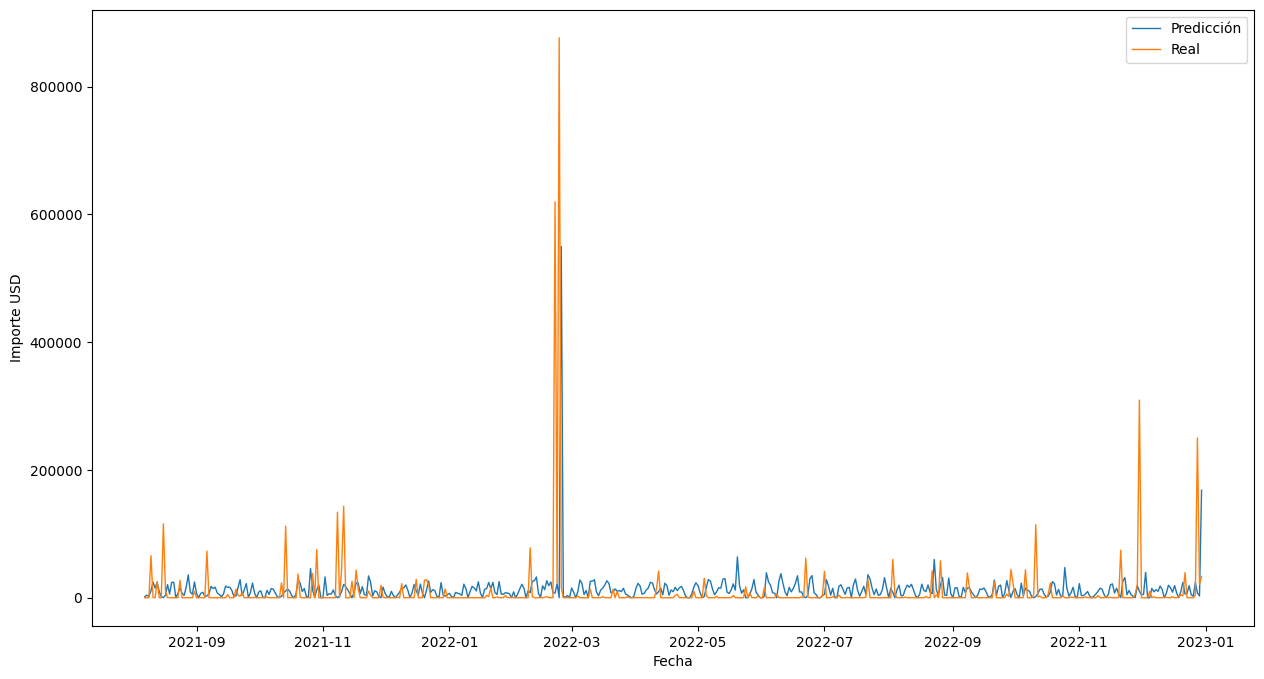

In [25]:
plt.figure(figsize = (15, 8))
plt.plot(dates, prices[ : -1], label = "Predicción", linewidth = 1)
plt.plot(dates, real_prices, label = "Real", linewidth = 1)
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Importe USD")
plt.show()

In [27]:
pred = pd.DataFrame({"Fecha" : dates, "Predicción" : prices[ : -1], "Real" : real_prices})

In [28]:
pred["Anno"] = pred["Fecha"].apply(lambda x : x.year)
pred["Mes"] = pred["Fecha"].apply(lambda x : x.month)

In [38]:
grouped = pred.groupby(["Anno", "Mes"]).agg({"Predicción" : "sum", "Real" : "sum", "Fecha" : "max"}).reset_index()

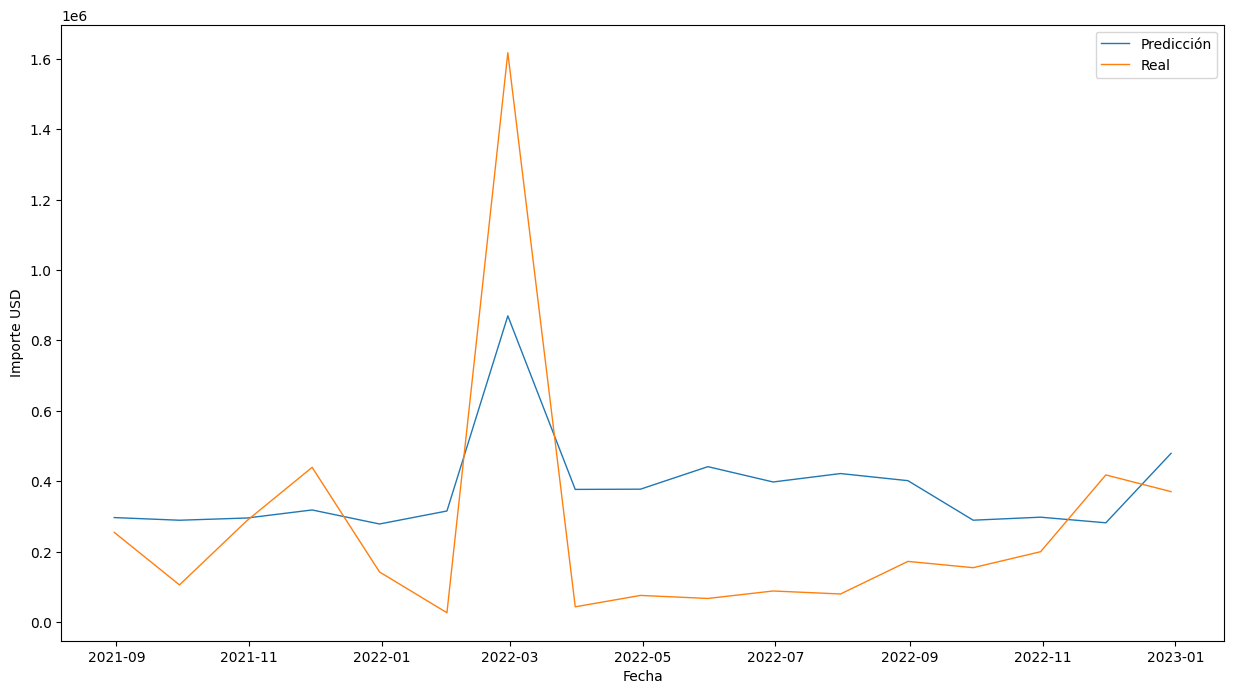

In [40]:
plt.figure(figsize = (15, 8))
plt.plot(grouped["Fecha"], grouped["Predicción"], label = "Predicción", linewidth = 1)
plt.plot(grouped["Fecha"], grouped["Real"], label = "Real", linewidth = 1)
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Importe USD")
plt.show()

In [42]:
presupuesto_predicho = grouped["Predicción"].sum()
presupuesto_real = grouped["Real"].sum()

In [43]:
presupuesto_predicho, presupuesto_real

(6428833.070812198, 4541482.81)

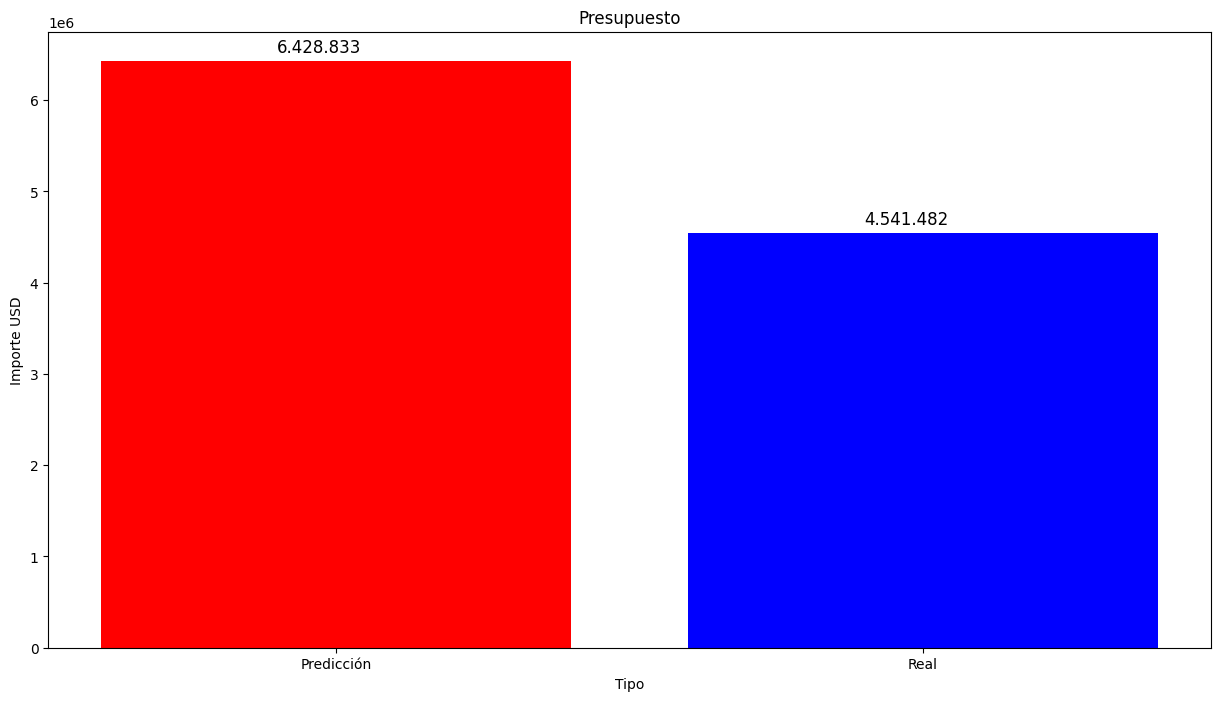

In [53]:
plt.figure(figsize = (15, 8))
plt.bar(["Predicción", "Real"], [presupuesto_predicho, presupuesto_real], color = ["red", "blue"])
plt.xlabel("Tipo")
plt.ylabel("Importe USD")
plt.title("Presupuesto")

for i, v in enumerate([presupuesto_predicho, presupuesto_real]):
    value = v
    v = str(int(v))
    v = ".".join([v[::-1][i : i + 3] for i in range(0, len(v), 3)])[::-1]
    plt.text(i - 0.1, value + 100000, v, color = "black", fontsize = 12)
plt.show()